In [1]:
!pip install textstat

     |████████████████████████████████| 3.0MB 4.2MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
import gensim
import ipywidgets as widgets
from IPython.display import clear_output, display
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
BAD_WORD_LIST = '/kaggle/input/swear-words/badwords.txt'
WORD2VEC_FILE = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'

/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/swear-words/badwords.txt
/kaggle/input/ift3395-ift6390-reddit-comments/data_test.pkl
/kaggle/input/ift3395-ift6390-reddit-comments/sample_submission.csv
/kaggle/input/ift3395-ift6390-reddit-comments/data_train.pkl


In [3]:
datasets = ['train', 'test']
input_path = '/kaggle/input/ift3395-ift6390-reddit-comments/'
data_train, data_test = [np.load(os.path.join(input_path, f'data_{dataset}.pkl'), allow_pickle=True) for dataset in datasets]

In [4]:
def to_dataframe(data):
    if len(data) == 2:
        comment, label = data
        result = pd.DataFrame({'comment': comment, 'label': label})
    else:
        result = pd.DataFrame({'comment': data})
    return result

In [5]:
train_df, test_df = (to_dataframe(data) 
                     for data in [data_train, data_test])

## Tokenization

Tokenize the comments into words and sentences and add the following data elements:
* `word_count`: The number of words
* `sentence_count`: The number of sentences

In [6]:
RE_WORD = re.compile(r'^[a-zA-Z]+')
RE_URL = re.compile(r'\w+://\S+')
STOPWORDS = set(stopwords.words('english'))

def filter_no_stopwords(token):
    return token.lower() not in STOPWORDS

def filter_words_only(token):
    return RE_WORD.match(token)

def transform_drop_urls(text):
    return RE_URL.sub('', text)

def transform_lowercase(value):
    return value.lower()

def transform_stem(value):
    return STEMMER.stem(value)

class Tokenizer:
    DEFAULT_TEXT_TRANSFORMS = [transform_drop_urls]
    DEFAULT_TOKEN_FILTERS = [filter_words_only, filter_no_stopwords]
    DEFAULT_TOKEN_TRANSFORMS = [transform_lowercase]
    def __init__(self):
        self.text_transforms = self.DEFAULT_TEXT_TRANSFORMS
        self.token_filters = self.DEFAULT_TOKEN_FILTERS
        self.token_transforms = self.DEFAULT_TOKEN_TRANSFORMS
        
    def __call__(self, data):
        return (self.process_item(item) for item in show_progress(data, desc='Tokenization'))
    
    def transform(self, token):
        for transform in self.token_transforms:
            token = transform(token)
        return token
    
    def process_item(self, text):
        for text_transform in self.text_transforms:
            text = text_transform(text)
        tokens = word_tokenize(text)
        return [
            self.transform(token) for token in tokens
            if all(
                token_filter(token)
                for token_filter in self.token_filters)]

In [7]:
def enhance_tokenization(df):
    tokenizer = Tokenizer()
    df['length'] = df.comment.str.len()
    tqdm.pandas('Tokenizing Words')
    df['words'] = df.comment.progress_apply(word_tokenize)
    tqdm.pandas('Tokenizing Sentences')
    df['sentences'] = df.comment.progress_apply(sent_tokenize)
    tqdm.pandas('Tokenizing - Normalized')
    df['tokens'] = df.comment.progress_apply(tokenizer.process_item)
    df['word_count'] = df.words.apply(len)
    df['sentence_count'] = df.sentences.apply(len)

enhance_tokenization(train_df)
train_df

,comment,label,length,words,sentences,tokens,word_count,sentence_count
0,"Honestly, Buffalo is the correct answer. I rem...",hockey,357,"[Honestly, ,, Buffalo, is, the, correct, answe...","[Honestly, Buffalo is the correct answer., I r...","[honestly, buffalo, correct, answer, remember,...",71,3
1,Ah yes way could have been :( remember when he...,nba,145,"[Ah, yes, way, could, have, been, :, (, rememb...",[Ah yes way could have been :( remember when h...,"[ah, yes, way, could, remember, drafted, thoug...",31,1
2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends,145,"[https, :, //youtu.be/6xxbBR8iSZ0, ?, t=40m49s...",[https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf y...,"[n't, find, already, nothing, ordinary, though...",28,2
3,He wouldn't have been a bad signing if we woul...,soccer,123,"[He, would, n't, have, been, a, bad, signing, ...",[He wouldn't have been a bad signing if we wou...,"[would, n't, bad, signing, would, n't, paid, e...",27,2
4,Easy. You use the piss and dry technique. Let ...,funny,212,"[Easy, ., You, use, the, piss, and, dry, techn...","[Easy., You use the piss and dry technique., L...","[easy, use, piss, dry, technique, let, drops, ...",52,4
...,...,...,...,...,...,...,...,...
69995,"Thank you, you confirm Spain does have nice pe...",europe,349,"[Thank, you, ,, you, confirm, Spain, does, hav...","[Thank you, you confirm Spain does have nice p...","[thank, confirm, spain, nice, people, bigots, ...",64,4
69996,Imagine how many he would have killed with a r...,leagueoflegends,58,"[Imagine, how, many, he, would, have, killed, ...",[Imagine how many he would have killed with a ...,"[imagine, many, would, killed, real, weapon]",12,1
69997,Yes. Only. As in the guy I was replying to was...,canada,176,"[Yes, ., Only, ., As, in, the, guy, I, was, re...","[Yes., Only., As in the guy I was replying to ...","[yes, guy, replying, claiming, number, much, n...",42,5
69998,Looking for something light-hearted or has a v...,anime,216,"[Looking, for, something, light-hearted, or, h...",[Looking for something light-hearted or has a ...,"[looking, something, light-hearted, unique, pl...",39,4


## Descriptive Statistics on Comment Length

In [8]:
length_desc_df = train_df.groupby('label')[['length', 'sentence_count', 'word_count']].describe()
length_desc_df

length                                                       \
                  count        mean         std   min     25%    50%     75%   
label                                                                          
AskReddit        3500.0  249.445714  328.089501  37.0   88.00  146.0  276.00   
GlobalOffensive  3500.0  185.980000  193.403430  19.0   77.00  120.0  206.00   
Music            3500.0  434.622286  863.363390  41.0   92.00  160.0  348.25   
Overwatch        3500.0  259.812857  421.758508  23.0   92.00  150.0  279.00   
anime            3500.0  255.135143  448.948241  19.0   88.00  142.0  261.00   
baseball         3500.0  181.277429  270.510338  37.0   77.00  116.0  199.00   
canada           3500.0  292.794000  382.706874  39.0  101.00  175.0  330.00   
conspiracy       3500.0  295.812571  417.757752  35.0   98.00  171.0  331.00   
europe           3500.0  282.921143  384.082428  19.0   96.00  170.0  320.00   
funny            3500.0  171.692000  256.376474  31.0   70.00  105.0  179.00   
gameofthrones    3500.0  251.771714  286.600729  39.0   90.00  150.5  327.00   
hockey           3500.0  190.659143  251.048988  27.0   78.00  120.0  209.25   
leagueoflegends  3500.0  216.734286  263.206921  36.0   83.00  134.0  247.25   
movies           3500.0  226.165714  329.330974  36.0   86.75  141.0  257.00   
nba              3500.0  179.694571  219.955377  36.0   76.00  117.5  204.00   
nfl              3500.0  217.918000  394.219110  36.0   84.00  133.5  232.00   
soccer           3500.0  190.266857  224.996818  38.0   79.00  124.0  217.25   
trees            3500.0  179.053714  240.486368  23.0   77.00  116.0  202.00   
worldnews        3500.0  291.044571  358.642944  38.0   99.00  175.0  331.00   
wow              3500.0  258.315429  335.797773  38.0   95.00  155.0  282.00   

                        sentence_count            ...             word_count  \
                    max          count      mean  ...  75%    max      count   
label                                             ...                          
AskReddit        6111.0         3500.0  3.210286  ...  4.0   57.0     3500.0   
GlobalOffensive  2484.0         3500.0  2.314857  ...  3.0   34.0     3500.0   
Music            9834.0         3500.0  4.326000  ...  4.0   74.0     3500.0   
Overwatch        9654.0         3500.0  3.094857  ...  4.0  108.0     3500.0   
anime            9569.0         3500.0  3.127714  ...  3.0  138.0     3500.0   
baseball         8611.0         3500.0  2.394857  ...  3.0   86.0     3500.0   
canada           8277.0         3500.0  3.373714  ...  4.0   74.0     3500.0   
conspiracy       7939.0         3500.0  3.578857  ...  4.0   55.0     3500.0   
europe           8556.0         3500.0  3.179714  ...  4.0   66.0     3500.0   
funny            7099.0         3500.0  2.431714  ...  3.0   62.0     3500.0   
gameofthrones    4995.0         3500.0  3.126286  ...  4.0   53.0     3500.0   
hockey           5722.0         3500.0  2.462286  ...  3.0   55.0     3500.0   
leagueoflegends  5584.0         3500.0  2.618571  ...  3.0   38.0     3500.0   
movies           9834.0         3500.0  2.899714  ...  3.0   95.0     3500.0   
nba              5953.0         3500.0  2.409143  ...  3.0   45.0     3500.0   
nfl              9226.0         3500.0  2.774286  ...  3.0  105.0     3500.0   
soccer           5756.0         3500.0  2.436286  ...  3.0   58.0     3500.0   
trees            8341.0         3500.0  2.650857  ...  3.0   82.0     3500.0   
worldnews        5395.0         3500.0  3.291429  ...  4.0   47.0     3500.0   
wow              3285.0         3500.0  3.072286  ...  3.0   54.0     3500.0   

                                                                          
                      mean         std   min    25%   50%    75%     max  
label                                                                     
AskReddit        53.109143   68.863792  10.0  19.00  32.0  60.00  1397.0  
GlobalOffensive  38.947429   38.755

### Length

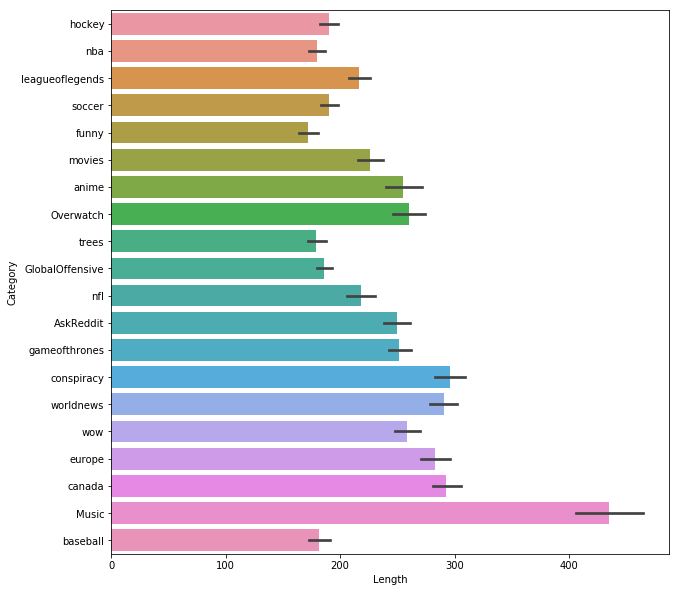

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    y='label',
    x='length',
    data=train_df)
_ = ax.set(xlabel='Length', ylabel='Category')

## Word Count

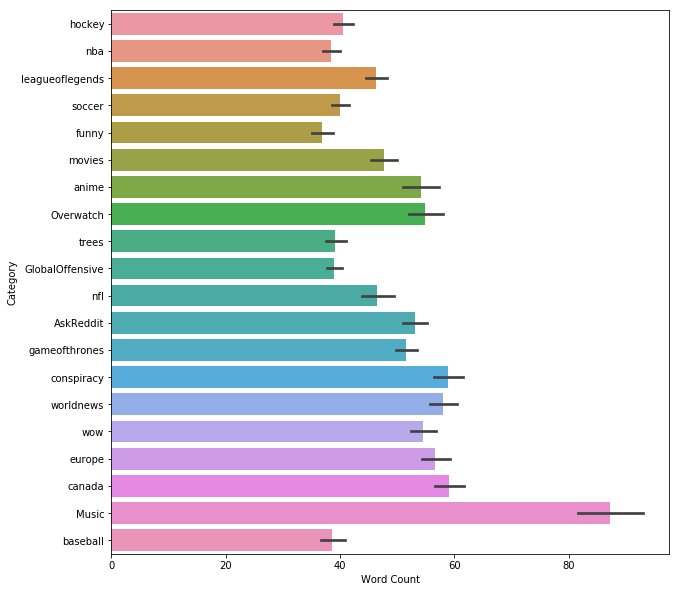

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    y='label',
    x='word_count',
    data=train_df)
_ = ax.set(xlabel='Word Count', ylabel='Category')

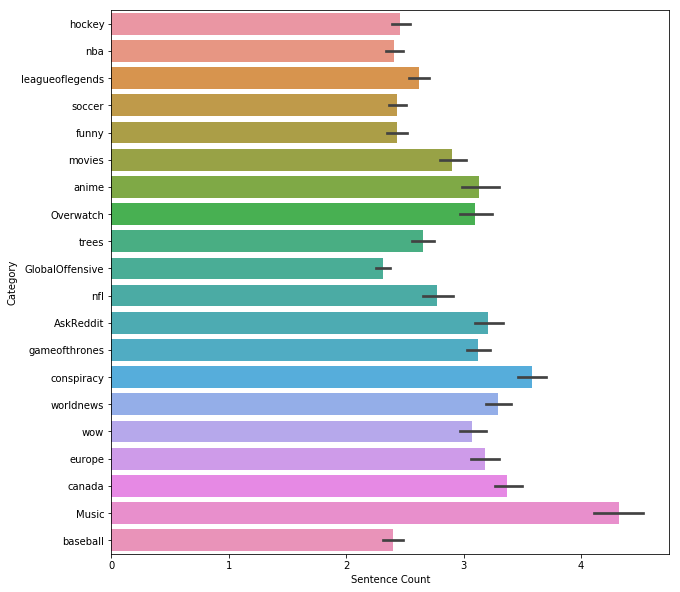

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    y='label',
    x='sentence_count',
    data=train_df)
_ = ax.set(xlabel='Sentence Count', ylabel='Category')

### Qualitative Observations
* The length of comments might be a useful feature in classifying (i.e. there is some variation across groups)
* The different measures of length (character count, word count, sentence count) produce similar results: likely, only one feature would be enough

## Swear Word Analysis
Determine the difference in the use of swear words by category.

The following list of swear words was used:
https://www.kaggle.com/highflyingbird/swear-words

In [12]:
def read_word_list(file_name):
    with open(file_name) as word_list_file:
        return set(word.strip() for word in word_list_file)

In [13]:
def enhance_bad_words(df):
    bad_words = read_word_list(BAD_WORD_LIST)
    df['bad_word_count'] = df.words.apply(lambda words: len(set(word.lower() for word in words) & bad_words))
    df['has_bad_words'] = df.bad_word_count > 0
    
enhance_bad_words(train_df)

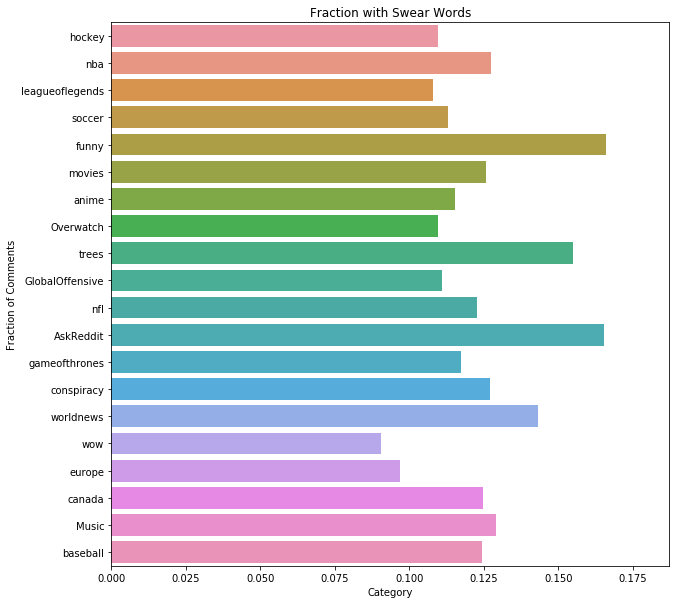

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(y='label', x='has_bad_words', data=train_df, errwidth=0)
_ = ax.set(title='Fraction with Swear Words', xlabel='Category', ylabel='Fraction of Comments')

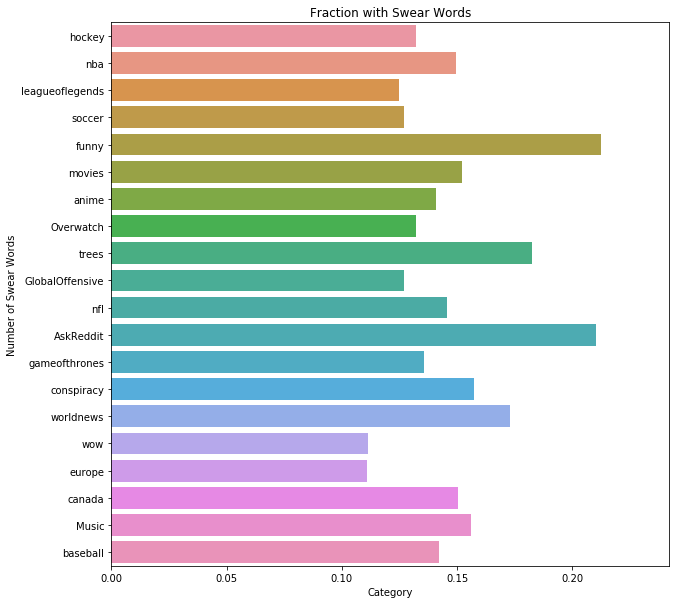

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(y='label', x='bad_word_count', data=train_df, errwidth=0)
_ = ax.set(title='Fraction with Swear Words', xlabel='Category', ylabel='Number of Swear Words')

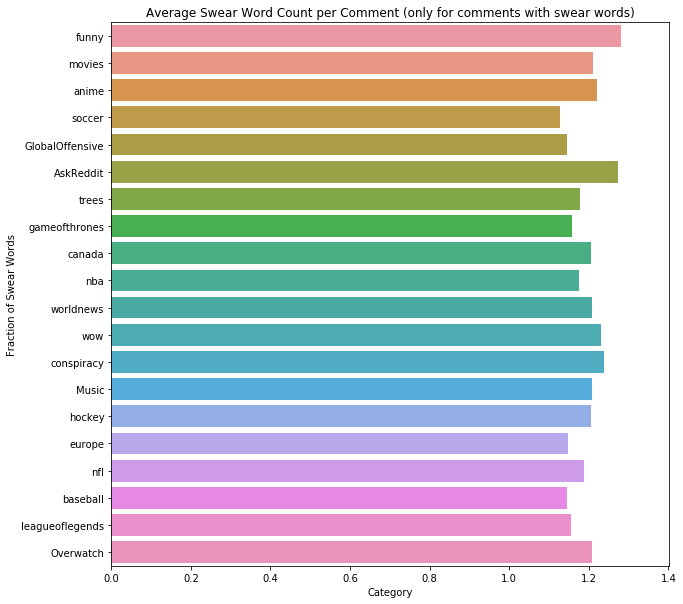

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(y='label', x='bad_word_count', data=train_df[train_df.has_bad_words], errwidth=0)
_ = ax.set(title='Average Swear Word Count per Comment (only for comments with swear words)', xlabel='Category', ylabel='Fraction of Swear Words')

### Qualitative Observations
* Some categories appear to have an unusually high or an unusually low number of curse words 
* The number of swear words per comment is not a useful category

## Reading Ease Statistics

Enhance the data set with the following metrics:
* Flesch Reading Ease (measures ease of reading)
* Smog Index (measures the use of complex words)
* Flesch-Kincaid Grade Level (an estimate of the grade level at which the text is written)
* Difficult Words: the number of difficult words

In [17]:
readability_stats = [
    ('flesch_reading_ease', 'Flesch Reading Ease'),
    ('smog_index', 'Smog Index'),
    ('flesch_kincaid_grade', 'Flesch-Kincaid Grade Level'), 
    ('difficult_words', 'Difficult Words')]
def enhance_readability(df):
    for item in readability_stats:
        key, label = item
        tqdm.pandas(desc=label)
        stat = getattr(textstat, key)
        df[key] = df.comment.progress_apply(stat)
        
enhance_readability(train_df)

In [18]:
keys = [key for key, _ in readability_stats]
train_df.groupby('label')[keys].describe()

flesch_reading_ease                                          \
                              count       mean        std      min      25%   
label                                                                         
AskReddit                    3500.0  70.099429  27.230072  -216.11  60.7875   
GlobalOffensive              3500.0  72.950820  29.953706  -296.71  64.7425   
Music                        3500.0  63.527349  35.587203  -801.26  51.8200   
Overwatch                    3500.0  69.464606  34.074540  -678.42  62.0100   
anime                        3500.0  68.636017  39.763099 -1626.96  59.6400   
baseball                     3500.0  73.954191  31.003668  -612.98  66.7400   
canada                       3500.0  59.990357  33.989018  -317.95  49.9575   
conspiracy                   3500.0  60.516609  36.292626  -756.26  50.8400   
europe                       3500.0  62.074909  30.252461  -482.04  50.6700   
funny                        3500.0  74.106551  27.163206  -471.22  64.7100   
gameofthrones                3500.0  70.091909  26.540218  -296.71  59.8100   
hockey                       3500.0  74.537377  23.489138  -143.41  66.0600   
leagueoflegends              3500.0  71.578294  36.978334  -899.06  64.2075   
movies                       3500.0  70.784791  35.243200 -1401.59  62.0100   
nba                          3500.0  75.471511  22.954882  -264.56  66.9100   
nfl                          3500.0  72.441417  26.786909  -218.82  64.7100   
soccer                       3500.0  72.763483  27.996836  -969.24  64.2000   
trees                        3500.0  75.972126  26.819569  -505.51  67.4200   
worldnews                    3500.0  60.330757  30.328233  -200.94  49.8200   
wow                          3500.0  69.723786  28.315887  -272.29  61.0500   

                                         smog_index            ...  \
                    50%      75%     max      count      mean  ...   
label                                                          ...   
AskReddit        74.900  86.0000  118.18     3500.0  2.545114  ...   
GlobalOffensive  78.250  88.5700  121.56     3500.0  1.653486  ...   
Music            71.120  85.0200  125.01     3500.0  3.803886  ...   
Overwatch        74.190  85.6150  123.93     3500.0  2.532771  ...   
anime            73.325  84.6800  120.04     3500.0  2.211229  ...   
baseball         78.250  89.2400  118.78     3500.0  1.521314  ...   
canada           65.965  78.7900  121.56     3500.0  2.771429  ...   
conspiracy       67.080  79.9000  117.16     3500.0  3.044857  ...   
europe           66.410  79.8025  124.10     3500.0  2.884886  ...   
funny            78.250  90.0900  119.53     3500.0  1.333029  ...   
gameofthrones    74.865  86.3075  125.96     3500.0  2.790514  ...   
hockey           78.250  88.4300  144.91     3500.0  1.574400  ...   
leagueoflegends  76.590  86.7100  125.11     3500.0  1.870314  ...   
movies           74.690  85.6900  119.53     3500.0  2.355771  ...   
nba              78.250  88.7400  149.31     3500.0  1.675057  ...   
nfl              76.560  86.7100  149.31     3500.0  1.796000  ...   
soccer           76.220  86.5825  120.55     3500.0  1.763943  ...   
trees            79.940  91.1500  117.16     3500.0  1.675171  ...   
worldnews        65.730  78.2500  118.52     3500.0  2.895200  ...   
wow              74.870  85.3600  122.58     3500.0  2.236343  ...   

                flesch_kincaid_grade        difficult_words             \
                                 75%    max           count       mean   
label                                                                    
AskReddit                     10.300  117.9          3500.0   6.139714   
GlobalOffensive                9.500   70.4          3500.0   4.982000   
Music                         12.600  154.6          3500.0  11.668286   
Overwatch                     10.500  223.9          3500.0   6.772000   
anime                         10.525  660.0          3500.0   6.74428

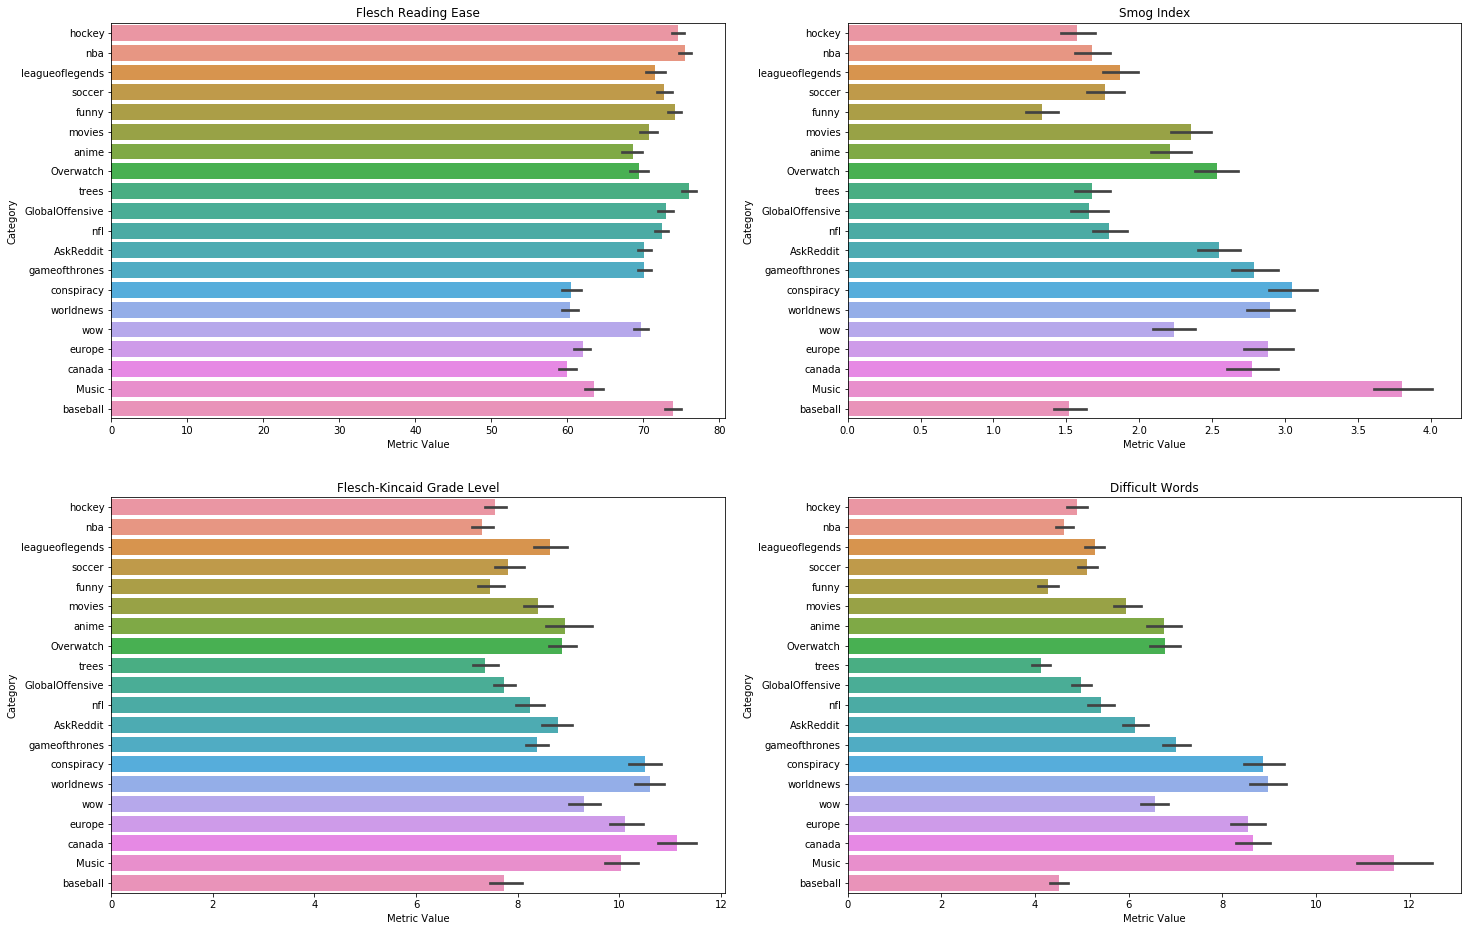

In [19]:
plt.figure(figsize=(10, 16))
plt.subplots_adjust(right=2)
for idx, item in enumerate(readability_stats):
    key, label = item
    plt.subplot(2, 2, idx + 1)
    ax = sns.barplot(y='label', x=key, data=train_df)
    _ = ax.set(title=label, xlabel='Metric Value', ylabel='Category')


### Qualitative Observations:
* There is significant variation from one subreddit to the next in most of the metrix.
* Introducing the Flesch-Kincaid Grade Level, the Smog Index and the Difficult Words would be redundant because they appear to be producing similar results. 

## Word2Vec Word Averaging

The word2vec model aims to represent natural language words in vector space with words with similar meanings located close together, having a smaller Euclidian distance to each other compared to unrelated words. It is typically achieved by training a shallow neural network on a very large corpus to predict words occurring close to each other. 

The approach used here is the following:
* Tokenize the Reddit comments into words
* Remove stopwords
* Compute the `word2vec` vectors for each remaining 



In [20]:
top_n_to_remove = 500
word_counter = Counter(tqdm(token for comment in train_df.tokens for token in comment))
frequency_sorted_words = list(reversed(sorted(word_counter.items(), key=lambda item: item[1])))
words_to_remove = set(word for word, count in frequency_sorted_words[:top_n_to_remove+1])

In [21]:
def remove_top_words(words, n=100):
    return [word for word in words if word not in words_to_remove]
train_df['tokens_no_top'] = train_df.tokens.progress_apply(remove_top_words)

In [22]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(WORD2VEC_FILE, binary=True)
default_shape = word2vec.vectors[0].shape
default_vector = np.zeros(default_shape)

In [23]:
def mean_word_vector(words):
    vector = np.mean([word2vec.get_vector(word) for word in words if word in word2vec.vocab], axis=0) 
    if vector.shape != default_shape:
        vector = default_vector
    return vector

In [24]:
tqdm.pandas('Computing Word2Vec Averages')
train_df['mean_word2vec'] = train_df.tokens_no_top.progress_apply(mean_word_vector)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [25]:
pca = PCA(2)
mean_word2vec_matrix = np.vstack(train_df.mean_word2vec)
mean_word2vec_pca2d = pca.fit_transform(mean_word2vec_matrix)

In [26]:
def visualize_dim_reduced(feature, dataset=train_df):
    SAMPLE_SIZE = 400
    labels = dataset.label.unique()
    label_checkboxes = {label: widgets.Checkbox(description=label) for label in labels}
    visualize_button = widgets.Button(description='Visualize')
    checkboxes = widgets.VBox(list(label_checkboxes.values()) + [visualize_button])
    plt.figure(figsize=(8, 8))
    def visualize(*args):
        clear_output()
        selected_labels = [label for label, checkbox in label_checkboxes.items() if checkbox.value]
        if not len(selected_labels):
            print("Nothing to output")
        selected_df = dataset[dataset.label.isin(selected_labels)]
        sample_size = min(len(selected_df), SAMPLE_SIZE)
        sample_df = selected_df.sample(sample_size)
        sample_pca = feature[sample_df.index]
        sample_pca_x, sample_pca_y = sample_pca[:, 0], sample_pca[:, 1]
        samples_by_label = [
            feature[selected_df[selected_df.label == label].index]
            for label in selected_labels]
        plt.subplot(121)
        ax = sns.scatterplot(x=sample_pca_x, y=sample_pca_y, hue=sample_df.label)
        ax.set(title='Word2Vec PCA Scatter')
        plt.subplot(122)
        for label_samples in samples_by_label:
            kde_x, kde_y = np.moveaxis(label_samples, 1, 0)
            ax = sns.kdeplot(kde_x, kde_y)
            ax.set(title='Word2Vec PCA KDE')

    visualize_button.on_click(visualize)
    display(checkboxes)

In [27]:
visualize_dim_reduced(mean_word2vec_pca2d)

<Figure size 576x576 with 0 Axes>

## TFIDF-Weighted Word2Vec

The idea is similar to word2vec averaging; however, rather than giving every word equal weight, it will average them in reverse proportion to their relative document frequency. 

In [28]:
def get_tfidf_weight(word, weights, vocabulary):
    idx = vocabulary.get(word)
    return weights[0, idx] if idx else 0.

def mean_word_vector_tfidf(words, weights, vocabulary):
    words_in_vocab = [word for word in words if word in word2vec.vocab]
    w2v_vectors = np.array([word2vec.get_vector(word) for word in words_in_vocab])
    word_weights = np.array(
        [get_tfidf_weight(word, weights, vocabulary) for word in words_in_vocab])
    vector = np.mean(w2v_vectors * word_weights[:, np.newaxis], axis=0) 
    if vector.shape != default_shape:
        vector = default_vector
    return vector

In [29]:
def enhance_tfidf_word2vec(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectors = tfidf_vectorizer.fit_transform(tqdm(df.comment))

    df['mean_tfidf_word2vec'] = [
        mean_word_vector_tfidf(tokens, weights, tfidf_vectorizer.vocabulary_)
        for tokens, weights in tqdm(zip(df.tokens, tfidf_vectors), total=len(df))]

In [30]:
enhance_tfidf_word2vec(train_df)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [31]:
pca = PCA(2)
mean_tfidf_word2vec_matrix = np.vstack(train_df.mean_tfidf_word2vec)
mean_tfidf_word2vec_pca2d = pca.fit_transform(mean_tfidf_word2vec_matrix)

In [32]:
visualize_dim_reduced(mean_tfidf_word2vec_pca2d)

<Figure size 576x576 with 0 Axes>

In [33]:
mean_tfidf_word2vec_matrix.shape

(70000, 300)

## TFIDF-Weighted Word2Vec - Fake Sample Data
This is an attempt to run the technique on samples that are made artificially dissimilar - to assess its maximum potential in its best case

In [34]:
fake_train_df = pd.DataFrame(
    [{'comment': 'hydrogen monoxide is a poisonous gaseous substance', 'label': 'science'},
     {'comment': 'chemistry studies the states of matter and the elements of which it is composed', 'label': 'science'},
     {'comment': 'artificial intelligence relies on calculus, linear algebra and algorithm analysis', 'label': 'science'},
     {'comment': 'astrophysics studies the motion of planets and the growth of the universe', 'label': 'science'},
     {'comment': 'basketball is a very popular sport in the united states', 'label': 'sports'},
     {'comment': 'football is called soccer in america and soccer is called football in england', 'label': 'sports'},
     {'comment': 'tennis is a sport that can be played one on one or in doubles', 'label': 'sports'},
     {'comment': 'in hockey you use a puck, and in soccer you kick a ball', 'label': 'sports'}])

fake_train_df

,comment,label
0,hydrogen monoxide is a poisonous gaseous subst...,science
1,chemistry studies the states of matter and the...,science
2,"artificial intelligence relies on calculus, li...",science
3,astrophysics studies the motion of planets and...,science
4,basketball is a very popular sport in the unit...,sports
5,football is called soccer in america and socce...,sports
6,tennis is a sport that can be played one on on...,sports
7,"in hockey you use a puck, and in soccer you ki...",sports


In [35]:
enhance_tokenization(fake_train_df)
fake_train_df

,comment,label,length,words,sentences,tokens,word_count,sentence_count
0,hydrogen monoxide is a poisonous gaseous subst...,science,50,"[hydrogen, monoxide, is, a, poisonous, gaseous...",[hydrogen monoxide is a poisonous gaseous subs...,"[hydrogen, monoxide, poisonous, gaseous, subst...",7,1
1,chemistry studies the states of matter and the...,science,79,"[chemistry, studies, the, states, of, matter, ...",[chemistry studies the states of matter and th...,"[chemistry, studies, states, matter, elements,...",14,1
2,"artificial intelligence relies on calculus, li...",science,81,"[artificial, intelligence, relies, on, calculu...","[artificial intelligence relies on calculus, l...","[artificial, intelligence, relies, calculus, l...",11,1
3,astrophysics studies the motion of planets and...,science,73,"[astrophysics, studies, the, motion, of, plane...",[astrophysics studies the motion of planets an...,"[astrophysics, studies, motion, planets, growt...",12,1
4,basketball is a very popular sport in the unit...,sports,55,"[basketball, is, a, very, popular, sport, in, ...",[basketball is a very popular sport in the uni...,"[basketball, popular, sport, united, states]",10,1
5,football is called soccer in america and socce...,sports,77,"[football, is, called, soccer, in, america, an...",[football is called soccer in america and socc...,"[football, called, soccer, america, soccer, ca...",13,1
6,tennis is a sport that can be played one on on...,sports,61,"[tennis, is, a, sport, that, can, be, played, ...",[tennis is a sport that can be played one on o...,"[tennis, sport, played, one, one, doubles]",14,1
7,"in hockey you use a puck, and in soccer you ki...",sports,55,"[in, hockey, you, use, a, puck, ,, and, in, so...","[in hockey you use a puck, and in soccer you k...","[hockey, use, puck, soccer, kick, ball]",14,1


In [36]:
enhance_tfidf_word2vec(fake_train_df)

In [37]:
pca = PCA(2)
fake_mean_tfidf_word2vec_matrix = np.vstack(fake_train_df.mean_tfidf_word2vec)
fake_mean_tfidf_word2vec_pca2d = pca.fit_transform(fake_mean_tfidf_word2vec_matrix)

In [38]:
visualize_dim_reduced(fake_mean_tfidf_word2vec_pca2d, fake_train_df)

<Figure size 576x576 with 0 Axes>

## Word Clouds
Display a "word cloud" visualization for each comment, highlighting the top words - providing ideas of what specific keywords could help with feature engineering

In [39]:
def concat_strings(series):
    return ' '.join(series)
reddits_agg_df = train_df.groupby('label').agg({'comment': [concat_strings]}).reset_index()
reddits_concat_df = pd.DataFrame({'label': reddits_agg_df.label, 'comments': reddits_agg_df.comment.concat_strings})
reddits_concat_df

,label,comments
0,AskReddit,Was at a trampoline centre for my sisters birt...
1,GlobalOffensive,Afraid I'll get addicted and fail school or sm...
2,Music,"/u/perpetualhorrors, your post has been remove..."
3,Overwatch,Right! He was a disruptor tank! Pull the dps o...
4,anime,Akagi is still Alpha as fuck and Sugawara is s...
5,baseball,Braves are a solid B in my book. The fact we'r...
6,canada,They don't have to - but do they have the righ...
7,conspiracy,Why? Why would they want isis in charge? To ke...
8,europe,I like people who can find something postitive...
9,funny,Easy. You use the piss and dry technique. Let ...


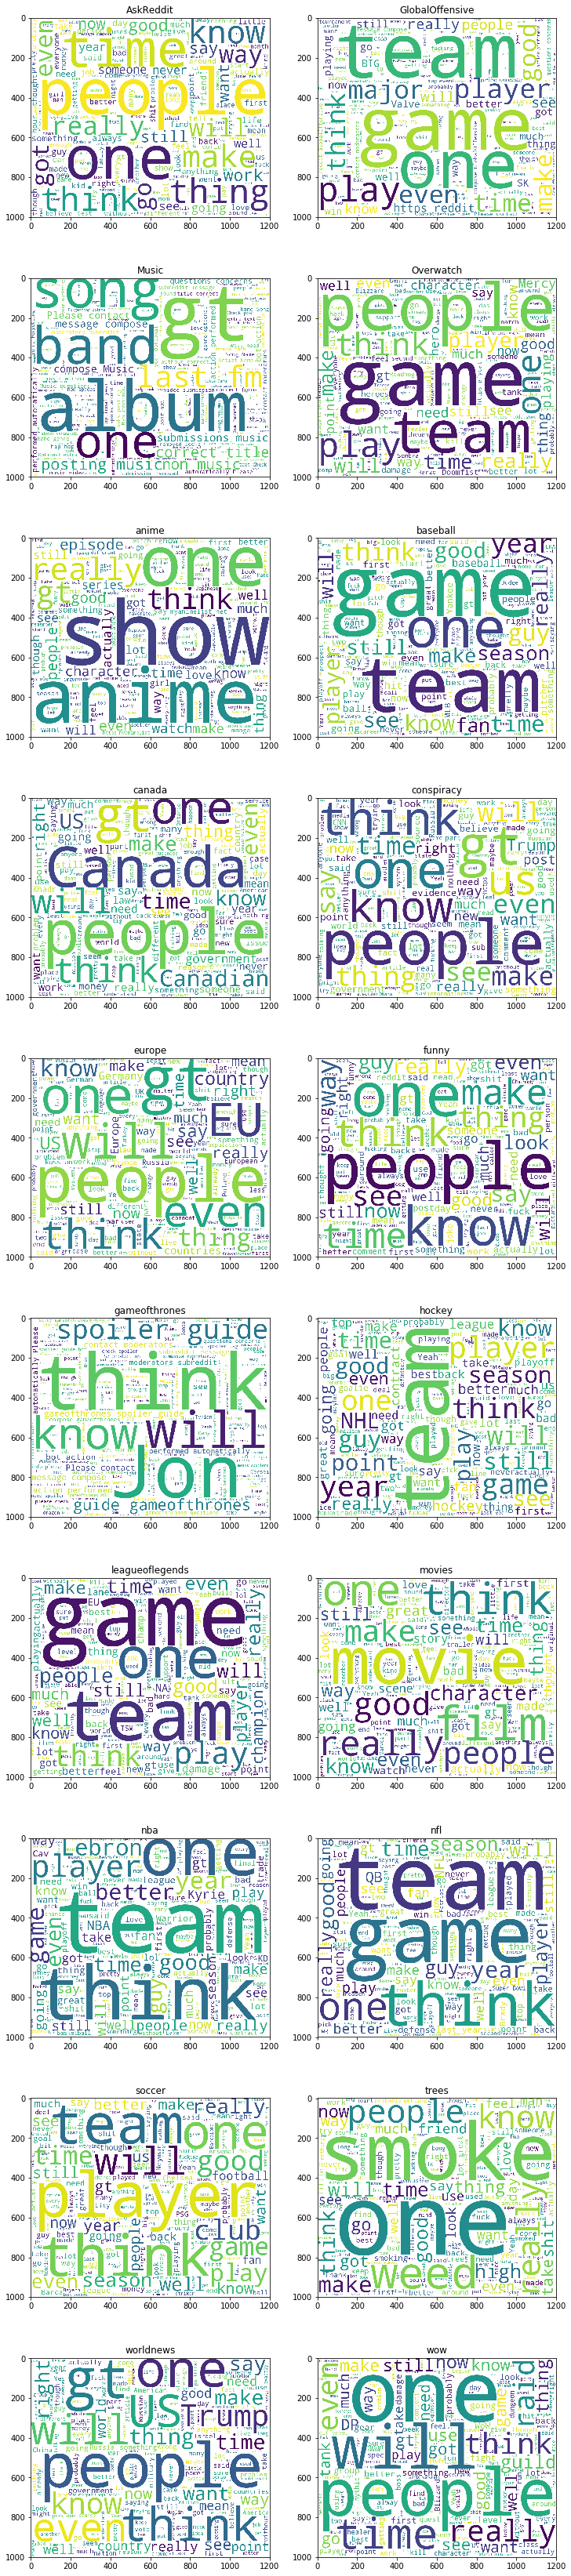

In [40]:
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000)
count = len(reddits_concat_df)
cols = 2
rows = math.ceil(count / cols)
plt.figure(figsize=(12, 60))

for idx, row in reddits_concat_df.iterrows():
    wordcloud_im = wordcloud.generate(row.comments)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(wordcloud_im)
    plt.title(row.label)